In [1]:
import pandas as pd
import numpy as np
from matplotlib import  pyplot as plt
%matplotlib inline
from time import time

from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.linear_model import RidgeCV,LassoCV,LassoLarsCV,ElasticNetCV,BayesianRidge,RANSACRegressor
from sklearn.svm import LinearSVR,SVR
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.pipeline import Pipeline



In [2]:
data = pd.read_csv("../data/interim/002-pe-features.csv",sep=";")

In [3]:
pred = list(data.columns)
pred.remove("hammer_price")
X,lbl = data.loc[:,pred],data.hammer_price

train,test,y_train,y_test = model_selection.train_test_split(X,lbl,train_size=0.7)

/usr/local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [82]:
def benchmark(clf ,X_train,y_train,X_test,y_test,feature_names=None):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.mean_squared_error(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if feature_names is not None:
            print("top 10 keywords per class:")
            top10 = np.argsort(clf.coef_)[-10:]
            print("%s: %s" % ('fake new has :', " ".join(feature_names[top10])))
        print()
    elif hasattr(clf,'feature_importances_'):
        if feature_names is not None:
            print("top 10 keywords per class:")
            top10 = np.argsort(clf.feature_importances_)[-10:]
            print(" ".join(feature_names[top10]))
        print()
    

    print("Regression report:")
    r2 = metrics.r2_score(y_test, pred)
    print(r2)  

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, np.sqrt(score),r2, train_time, test_time


In [ ]:
def tuning(clf,x,y,params):
    
    

In [83]:
clf = Pipeline([
        ('STD',StandardScaler()),
        ('feature_selection',SelectKBest(f_regression, k=10)),
        ('regression', RandomForestRegressor(n_estimators=100,n_jobs=2))
    ])

benchmark(clf,train,y_train,test,y_test,feature_names=None)

________________________________________________________________________________
Training: 
Pipeline(memory=None,
     steps=[('STD', StandardScaler(copy=True, with_mean=True, with_std=True)), ('feature_selection', SelectKBest(k=10, score_func=<function f_regression at 0x1084a2048>)), ('regression', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=...imators=100, n_jobs=2,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])
train time: 5.196s
test time:  0.515s
accuracy:   228759542479.003
Regression report:
0.322707319637



('Pipeline',
 478288.13750604686,
 0.32270731963729837,
 5.1960608959198,
 0.5147418975830078)

In [10]:
scores = f_regression(X,lbl)

([<matplotlib.axis.XTick at 0x114fd61d0>,
 <a list of 20 Text xticklabel objects>)

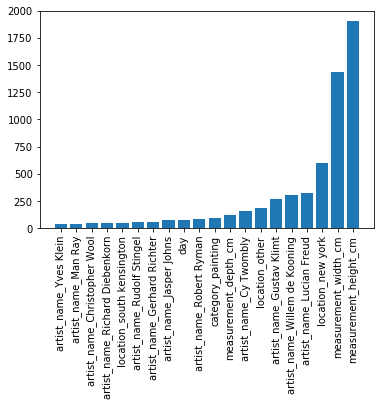

In [11]:
x = np.argsort(scores[0])[-20:]
plt.bar(range(0,len(x)),scores[0][x])
plt.xticks(range(0,len(x)),tuple(X.columns.values[x]),rotation='vertical')

In [12]:
clf = RandomForestRegressor(n_estimators=100,criterion='mse',n_jobs=-1,verbose=1)

In [13]:
clf.fit(train,y_train)

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=1, warm_start=False)

In [14]:
y_pred = clf.predict(test)
print(metrics.r2_score(y_test, y_pred))
importance = clf.feature_importances_

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.5s finished


0.543550043219


([<matplotlib.axis.XTick at 0x122931a90>,
 <a list of 20 Text xticklabel objects>)

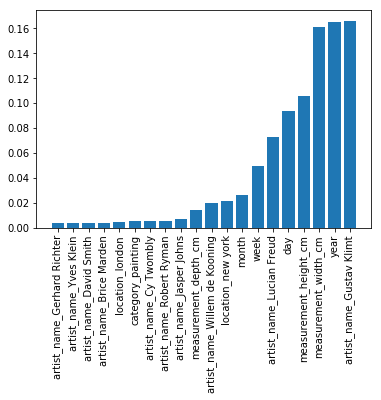

In [15]:
x = np.argsort(importance)[-20:]
plt.bar(range(0,len(x)),importance[x])
plt.xticks(range(0,len(x)),tuple(X.columns.values[x]),rotation='vertical')

# Conclusion 

#### Since both the ANOVA regression scores and Tree-based feature importance point out that the measurements of the peice plays an important role in the price, We need to do some important feature engineering.

In [12]:

def main(X,X_t,y,y_t):
    print(X.shape)
    x_train,x_test,preprocessor = prepare_data(X,X_t)

    results = []
    for clf, name in (
            (OneVsRestClassifier(RidgeClassifier(tol=1e-2, solver="lsqr")), "Ridge Classifier"),
            (OneVsRestClassifier(Perceptron(n_iter=50), "Perceptron")),
            (OneVsRestClassifier(PassiveAggressiveClassifier(n_iter=50)), "Passive-Aggressive"),
            (OneVsRestClassifier(KNeighborsClassifier(n_neighbors=10)), "kNN"),
            (OneVsRestClassifier(RandomForestClassifier(n_estimators=300)), "Random forest")):
        print('=' * 80)
        print(name)
        results.append(benchmark(clf,x_train,y,x_test,y_t,None))

    for penalty in ["l2", "l1"]:
        print('=' * 80)
        print("%s penalty" % penalty.upper())
        # Train Liblinear model
        results.append(benchmark(OneVsRestClassifier(LinearSVC(loss='l2', penalty=penalty,
                                           dual=False, tol=1e-3)),x_train,y,x_test,y_t,None))

        # Train SGD model
        results.append(benchmark(OneVsRestClassifier(SGDClassifier(alpha=.0001, n_iter=50,
                                               penalty=penalty)),x_train,y,x_test,y_t,None))

    # Train SGD with Elastic Net penalty
    print('=' * 80)
    print("Elastic-Net penalty")
    results.append(benchmark(OneVsRestClassifier(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty="elasticnet")),x_train,y,x_test,y_t,None))

    # Train NearestCentroid without threshold
    print('=' * 80)
    print("NearestCentroid (aka Rocchio classifier)")
    results.append(benchmark(OneVsRestClassifier(NearestCentroid()),x_train,y,x_test,y_t,None))

    # Train sparse Naive Bayes classifiers
    print('=' * 80)
    print("Naive Bayes")
    results.append(benchmark(OneVsRestClassifier(MultinomialNB(alpha=.01)),x_train,y,x_test,y_t,None))
    results.append(benchmark(OneVsRestClassifier(BernoulliNB(alpha=.01)),x_train,y,x_test,y_t,None))

    print('=' * 80)
    print("LinearSVC with L1-based feature selection")
    # The smaller C, the stronger the regularization.
    # The more regularization, the more sparsity.
    results.append(benchmark(Pipeline([
        ('feature_selection', OneVsRestClassifier(LinearSVC(penalty="l1", dual=False, tol=1e-3))),
        ('classification', OneVsRestClassifier(LinearSVC()))
    ]),x_train,y,x_test,y_t,None))

    # make some plots

    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(4)]

    clf_names, score, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    plt.figure(figsize=(12, 8))
    plt.title("Score")
    plt.barh(indices, score, .2, label="score", color='navy')
    plt.barh(indices + .3, training_time, .2, label="training time",
             color='c')
    plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()


________________________________________________________________________________
Training: 
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=2,
           oob_score=False, random_state=None, verbose=1, warm_start=False)


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   44.6s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:  1.6min finished


train time: 98.752s


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.7s finished


test time:  0.755s
accuracy:   189870648604.387
top 10 keywords per class:
location_new york artist_name_Willem de Kooning month week artist_name_Lucian Freud measurement_height_cm day year artist_name_Gustav Klimt measurement_width_cm

Regression report:
0.437846399228



('RandomForestRegressor',
 189870648604.3873,
 98.7522292137146,
 0.7546610832214355)

array(['measurement_depth_cm', 'day', 'month'], dtype=object)